### SVM原理
SVM有很多实现，在此只关注其最流行的一种实现，即**序列最小优化**算法。而后，介绍使用**核函数**的方式将SVM拓展到更多的数据集。


分隔超平面用于将数据集分隔开。如果数据点在二维平面，则分隔超平面是直线。数据点在三维平面，则分隔超平面是平面。即位于N维的数据集，需要N-1维的对象对其进行分隔。这个对象称为**超平面（hyperplane）**，也就是分类的决策边界。
数据点到分隔超平面的距离称为间隔。我们希望找到离超平面最近的点，确保它们离分隔面的距离尽可能远。点到分隔面的距离被称为**间隔（margin）**

**支持向量（support vector）** 就是离分隔超平面最近的那些点。最大化支持向量到分隔面的距离即目标。

**如何求解分隔超平面：**
分隔超平面的形式可以写为$w^Tx+b$。点A到分隔超平面的距离为$\frac{|w^TA+b|}{||w||}$。
分类器也就相当与一个函数$f(w^Tx+b)$如果u<0,则f(u)输出-1，否则输出1 标签我们采用1和-1而不是0和1 因为这样间隔可以表示为$label*(w^Tx+b)$,不会出现负的间隔。
我们的目标是求解w和b。因此要找到具有最小间隔的数据点，然后使其最大化。即$$arg max\{min_n(lable\cdot(w^Tx+b))\cdot\frac{1}{||w||}\}$$
求解以上问题相对困难。因此我们需要固定一个因子而最大化其它因子。离超平面最近的点$label*(w^Tx+b)=1$,越远的点越大。从而有约束条件$label*(w^Tx+b)\ge1$,由此可以用拉格朗日乘子法求解

最后优化目标函数为:
$$max_a[\sum_{i=1}^m\alpha-\frac{1}{2}\sum_{i,j=1}^mlabel^{(i)}\cdot a_i \cdot a_j<x^{(i)},x^{(j)}>]$$
约束条件为:
$$c\ge\alpha\ge0,\sum_{i-1}^m\alpha_i\cdot label^{(i)}=0$$
(感觉原理方面书中并不具体，还是需要在《机器学习》中学习)

**SMO算法**:即*序列最小优化（Sequential Minimal Optimization）*

目标：求出一系列$\alpha$和b，从而计算权重向量w，得到分隔超平面

工作原理：每次循环中选择两个$\alpha$进行优化处理。一旦找到一对合适的$\alpha$,那么就增大其中一个同时减少另一个。合适的两个条件:
* 两个$\alpha$在间隔边界之外
* 这两个$\alpha$还没有进行过区间优化处理或者不在边界上

In [4]:
#加载数据
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat
#随机选择函数
def selectJrand(i,m):
    j=i #we want to select any J not equal to i
    while (j==i):
        j = int(random.uniform(0,m))
    return j
#辅助函数，用于调整大于H或小于L的alpha值。
def clipAlpha(aj,H,L):
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj
dataArr,labelArr=loadDataSet('testSet.txt')


In [11]:
#SMO函数伪代码
#创建一个alpha向量并将其初始化为0向量
#当迭代次数小于最大迭代次数时（外循环）
#    对数据集中的每个数据向量（内循环）：
#        如果该数据向量可以被优化：
#            随机选择另外一个数据向量
#            同时优化这两个向量
#            如果两个向量都不能被优化，退出内循环
#    如果所有向量都没有被优化，增加迭代数目，继续下一次循环
#简化的SMO函数 简化SMO与SMO算法的唯一不同在于选择alpha的方式上。完整版的Platt SMO算法应用了一些能够提速的启发方法。
from numpy import *
from time import sleep
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):#有数据集、类别标签、常数c、容错率、取消前最大的循环次数
    dataMatrix = mat(dataMatIn); labelMat = mat(classLabels).transpose()
    b = 0; m,n = shape(dataMatrix)
    alphas = mat(zeros((m,1)))
    iter = 0
    while (iter < maxIter):
        alphaPairsChanged = 0  #用于记录alpha是否已被优化
        for i in range(m):
            fXi = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
            Ei = fXi - float(labelMat[i])
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                j = selectJrand(i,m)  #随机选择第二个alpha
                fXj = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                alphaIold = alphas[i].copy(); alphaJold = alphas[j].copy();
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H: print("L==H"); continue
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                if eta >= 0: print("eta>=0"); continue
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j],H,L)
                if (abs(alphas[j] - alphaJold) < 0.00001): print("j not moving enough"); continue #如果alpha[j]存在存在微变，则退出循环
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j]#对i进行修改 修改量与j相同，但是方向相反
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                print("iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
        if (alphaPairsChanged == 0): iter += 1
        else: iter = 0
        print("iteration number: %d" % iter)
    return b,alphas
b,alphas=smoSimple(dataArr,labelArr,0.6,0.001,40)


L==H
L==H
L==H
L==H
iter: 0 i:4, pairs changed 1
L==H
iter: 0 i:8, pairs changed 2
L==H
j not moving enough
j not moving enough
j not moving enough
iter: 0 i:56, pairs changed 3
L==H
L==H
L==H
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
iteration number: 0
L==H
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
L==H
L==H
L==H
L==H
L==H
j not moving enough
L==H
L==H
L==H
iter: 0 i:52, pairs changed 1
iter: 0 i:54, pairs changed 2
j not moving enough
j not moving enough
L==H
iteration number: 0
j not moving enough
j not moving enough
L==H
L==H
iter: 0 i:23, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 0 i:56, pairs changed 2
iter: 0 i:94, pairs changed 3
j not moving enough
iteration number: 0
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enou

L==H
j not moving enough
j not moving enough
iteration number: 16
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
iteration number: 17
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
iteration number: 18
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 19
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 20
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 21
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
iteration number: 22
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
iteration number: 23
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
iteration number: 24
j not moving enough
j not moving enough
j

iteration number: 6
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
iteration number: 8
j not moving enough
j not moving enough
iteration number: 9
j not moving enough
iter: 9 i:54, pairs changed 1
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
iteration number: 2
iter: 2 i:17, pairs changed 1
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
iter: 0 i:55, pairs changed 1
iteration number: 0
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
iteration number: 7
j not movi

j not moving enough
iteration number: 10
iter: 10 i:17, pairs changed 1
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
iteration number: 8
j not moving enough
j not moving enough
iteration number: 9
j not moving enough
j not moving enough
iteration number: 10
j not moving enough
j not moving enough
iteration number: 11
j not moving enough
j not moving enough
iteration number: 12
j not moving enough
j not moving enough
iteration number: 13
iter: 13 i:29, pairs changed 1
j not moving enough
iteration number: 0
j not moving 

In [15]:
print(b)
print(alphas[alphas>0])#数组过滤 只适用于NumPy类型
print(shape(alphas[alphas>0]))#返回支持向量个数
#打印支持向量
for i in range(100):
    if alphas[i]>0.0:print(dataArr[i],labelArr[i])

-3.75567
[[0.09230056 0.27365941 0.04499814 0.32096183]]
(1, 4)
[4.658191, 3.507396] -1.0
[3.457096, -0.082216] -1.0
[5.286862, -2.358286] 1.0
[6.080573, 0.418886] 1.0


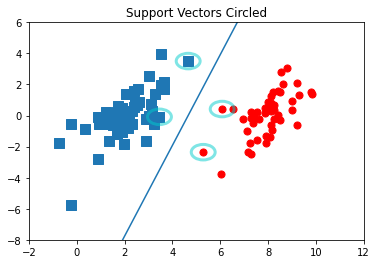

In [21]:
#对支持向量作图表示
from numpy import *
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

xcord0 = []
ycord0 = []
xcord1 = []
ycord1 = []
markers =[]
colors =[]
fr = open('testSet.txt')
for line in fr.readlines():
    lineSplit = line.strip().split('\t')
    xPt = float(lineSplit[0])
    yPt = float(lineSplit[1])
    label = int(lineSplit[2])
    if (label == -1):
        xcord0.append(xPt)
        ycord0.append(yPt)
    else:
        xcord1.append(xPt)
        ycord1.append(yPt)

fr.close()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('Support Vectors Circled')
circle = Circle((4.658191, 3.507396), 0.5, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
ax.add_patch(circle)
circle = Circle((3.457096, -0.082216), 0.5, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
ax.add_patch(circle)
circle = Circle((5.286862, -2.358286), 0.5, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
ax.add_patch(circle)
circle = Circle((6.080573, 0.418886), 0.5, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
ax.add_patch(circle)
b = -3.75567; w0=0.8065; w1=-0.2761
x = arange(-2.0, 12.0, 0.1)
y = (-w0*x - b)/w1
ax.plot(x,y)
ax.axis([-2,12,-8,6])
plt.show()

### 核函数（kernel）
在此介绍一种最为流行的*核函数径向基函数（radial bias function）*
以下的图在二维平面很难用一条直线分隔，但是这里确实存在分隔两种点的模式，即画一个圆，但对分类器而言，它很难意识到这一点。于是我们可以通过核函数将数据映射到高维空间。

核函数可以理解为包装器（warpper）或者接口（interface），它可以将数据从某个很难处理的形式转化为一个较容易处理的形式。

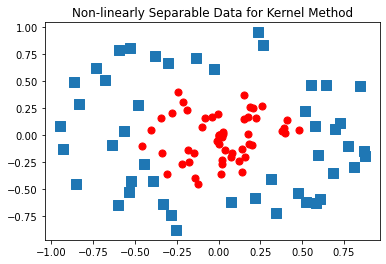

In [22]:
from numpy import *
import matplotlib
import matplotlib.pyplot as plt

xcord0 = []; ycord0 = []; xcord1 = []; ycord1 = []
fw = open('testSetRBF2.txt', 'w')#generate data

fig = plt.figure()
ax = fig.add_subplot(111)
xcord0 = []; ycord0 = []; xcord1 = []; ycord1 = []
for i in range(100):
    [x,y] = random.uniform(0,1,2)
    xpt=x*cos(2.0*pi*y); ypt = x*sin(2.0*pi*y)
    if (x > 0.5):
        xcord0.append(xpt); ycord0.append(ypt)
        label = -1.0
    else:
        xcord1.append(xpt); ycord1.append(ypt)
        label = 1.0
    fw.write('%f\t%f\t%f\n' % (xpt, ypt, label))
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('Non-linearly Separable Data for Kernel Method')
plt.show()
fw.close()

**径向基核函数**:采用向量作为自变量的函数，能够基于向量距离运算输出一个标量。

径向基核函数的高斯版本基本公式为:
$$k(x,y)=exp(\frac{-||x-y||^2}{2\sigma^2})$$
其中$\sigma$是用户定义的用于确定到达率(reach)或者说函数值跌落到0的速度参数。

In [24]:
#核转换函数
def kernelTrans(X, A, kTup):
    m,n = shape(X)
    K = mat(zeros((m,1)))
    if kTup[0]=='lin': K = X * A.T   
    elif kTup[0]=='rbf':
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T
        K = exp(K/(-1*kTup[1]**2)) 
    else: raise NameError('Houston We Have a Problem -- That Kernel is not recognized')
    return K

class optStruct:
    def __init__(self,dataMatIn, classLabels, C, toler, kTup):  
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m,1)))
        self.b = 0
        self.eCache = mat(zeros((self.m,2))) 
        self.K = mat(zeros((self.m,self.m)))
        for i in range(self.m):
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)

### 总结
SVM优缺点：
* 优点：泛化错误率低，计算开销不大，结果易解释。
* 缺点：对参数调节和核函数的选择敏感，原始分类器不不加修改仅适用于处理二类问题。
* 适用数据类型：数值型和标称型数据。

这一章原理上的缺失比较严重，这样来看代码就有些效率低下，还需多看几遍。